<a href="https://colab.research.google.com/github/Uzayisenga/4/blob/master/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [7]:
from re import VERBOSE
from numpy.lib.arraysetops import unique
class ScratchDecesionTreeClassifierDepth1():
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        # a root so that we can know where we started
        self.root = None
        
    def fit(self, X,y):
        # grow tree
        # apply a safety check
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)
        
    # function to grow the tree
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        # apply the stopping criteria of our growing tree
        if(depth >= self.max_depth
          or n_labels == 1
          or n_samples < self.min_samples_split):
            # if the condition is true that would mean that we are at the leaf node
            # check for the common label in our node
            leaf_value = self._most_common_label(y)
            # use our class to store the node information
            return Node(value=leaf_value)
        
        # if we did not meet the stopping criteria
        feat_idxs = np.random.choice(n_features, self.n_feats,replace=False)
        
        # do a greedy search
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:,best_feat], best_thresh)
        
        # continue growing
        left = self._grow_tree(X[left_idxs,:], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs,:], y[right_idxs], depth+1)
        
        node = Node(best_feat, best_thresh, left, right)
        return node

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idxs, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            # lets go over all threshold
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                # calculating the information gain
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh
    
    # a function to calculate the information gain
    def _information_gain(self, y, X_column, split_thresh):
        # calculate the parent entropy
        parent_gini = gini(y)
        
        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        
        if len(left_idxs) == 0 or len(right_idxs)==0:
            return 0

        # calculate the weighted average child entropy
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_g, e_g = gini(y[left_idxs]), gini(y[right_idxs])
        child_gini = (n_l/n) * e_g + (n_r/n) *e_g
        
        # calculating the information gain
        ig = parent_gini - child_gini
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
    
    def predict(self, X):
        # traverse our tree
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    # a function helper for prediction
    def _traverse_tree(self, x, node):
        # check for the stopping criteria
        if node.is_leaf_node():
            return node.value
        # check if we go from left or right
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
    
    # function to check the common label in our node
    def _most_common_label(self, y):
        # calculating the number of occurencies in y using counter
        counter = Counter(y)
        # getting the value of the most common label
        most_common = counter.most_common(1)[0][0]
        return most_common
        

In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X,y,model,step=0.01,
                    title='decision region',
                    xlabel='xlabel',
                    ylabel='ylabel',
                    target_names=['versicolor', 'virginica']):
    
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

In [9]:
X=np.array([0,2,1,-1,4])
y=np.array([0,0,0,1,1])

threshold_value=np.unique(X)
print('threshold_value',threshold_value)

threshold_value [-1  0  1  2  4]


In [10]:
u,counts=np.unique(y,return_counts=True)
print('unique',u,'unique_counts',counts)


unique [0 1] unique_counts [3 2]


In [11]:
def _gini(X):
    unique,count= np.unique(X, return_counts=True)
    tmp=0
    for i in unique:
        tmp+=(count[unique==i]/np.sum(count))**2
    return 1-tmp

In [12]:
for i in threshold_value[1:]:
               c1=y[X <i]
               c2=y[X >=i]


               print(i,'c1',c1,'c2',c2)
               print(i,'gini_left:',_gini(c1),'gini_right:',_gini(c2))

0 c1 [1] c2 [0 0 0 1]
0 gini_left: [0.] gini_right: [0.375]
1 c1 [0 1] c2 [0 0 1]
1 gini_left: [0.5] gini_right: [0.44444444]
2 c1 [0 0 1] c2 [0 1]
2 gini_left: [0.44444444] gini_right: [0.5]
4 c1 [0 0 0 1] c2 [1]
4 gini_left: [0.375] gini_right: [0.]


In [13]:
for i in threshold_value[1:]:
               c1=y[X <i]
               c2=y[X >=i]
               left=len(c1)/(len(c1)+len(c2))*_gini(c1)
               right=len(c2)/(len(c1)+len(c2))*_gini(c2)
               gain=_gini(X)-left-right
               print(i,gain)


0 [0.5]
1 [0.33333333]
2 [0.33333333]
4 [0.5]


In [14]:
X=np.array([[-0.44699,-2.807],[-1.4621,-2.4586],
            [0.10645,1.9242],[-3.5944,-4.0112],
            [0.9888,4.5718],[-3.1625,-3.9606],
            [0.56421,0.72888],[-0.60216,8.4636],
            [-0.61251,-0.75345],[-0.73535,-2.2718],
            [-0.80647,-2.2135],[0.86291,2.5946],
            [-3.11108,0.15394],[-2.9362,2.5462],
            [-0.57242,-2.9915],[1.4771,3.4896],
            [-0.58619,0.37158],[0.6017,4.3439],
            [-2.1086,8.3428],[-410113,-4.353],
            [-1.9948,-1.3927],[0.35084,-0.031994],
            [0.96765,7.8929],[-1.281,15.6824],
            [0.96765,10.083],[1.3763,1.3347],
            [-2.3234,-2.5323],[-2.9452,-1.8219],
            [0.14654,-0.28733],[0.5461,5.8245],
            [-0.65259,9.3444],[0.59912,5.3524],
            [0.50214,-0.31818],[-3.0603,-3.6461],
            [-6.6797,0.67661],[-2.353,-0.72261],
            [1.1319,2.4023],[-0.12243,9.0162],
            [-2.5677,13.1779],[0.057313,5.4681]
            ])
y=np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

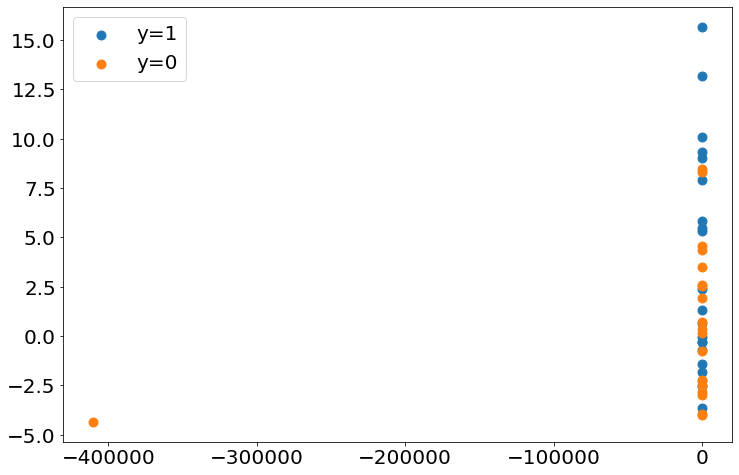

In [15]:
fig=plt.subplots(figsize=(12,8))
plt.rcParams["font.size"]=20
plt.scatter(X[y==1,0] ,X[y==1,1],s=80,label='y=1')
plt.scatter(X[y==0,0] ,X[y==0,1],s=80,label='y=0')
plt.legend();

In [16]:
from sklearn.model_selection  import train_test_split
X_train,X_valid,y_train,y_valid=\
train_test_split(X,y,train_size=0.8,random_state=None)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(32, 2)
(32,)
(8, 2)
(8,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
# entropy function as a global function
def entropy(y):
    # calculate the number of occurences of all class labels
    hist = np.bincount(y)
    ps = hist/ len(y)
    # apply the formula for entropy
    return -np.sum([p*np.log2(p) for p in ps if p>0])

# gini as a global function
def gini(y):
    unique,count = np.unique(y,return_counts=True)
    tmp = 0
    for i in unique:
        tmp += (count[unique==i]/np.sum(count))**2
    return 1-tmp

# a helper class to store information of the node
class Node:
    def __init__(self, feature=None, threshold=None,left=None,right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    # a helper function to determine if we are at the leafnode
    def is_leaf_node(self):
        return self.value is not None

In [25]:
from collections import Counter

In [26]:
    def _most_common_label(self, y):
        # calculating the number of occurencies in y using counter
        counter = Counter(y)
        # getting the value of the most common label
        most_common = counter.most_common(1)[0][0]
        return most_common

In [27]:
clf1 = ScratchDecesionTreeClassifierDepth1(max_depth=2)
clf1.fit(X_train,y_train)
  

In [28]:
y_pred = clf1.predict(X_test)

In [29]:
print(y_pred)
print(X_valid)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[ 0.86291   2.5946  ]
 [-0.73535  -2.2718  ]
 [-1.281    15.6824  ]
 [-2.1086    8.3428  ]
 [ 0.6017    4.3439  ]
 [ 0.35084  -0.031994]
 [-2.5677   13.1779  ]
 [-0.65259   9.3444  ]]


In [40]:
X.shape[0] != y.shape[0]

True

In [41]:
X = X.transpose()

In [47]:
y_pred = clf1.predict(X_test)

In [48]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('accuracy',accuracy)
print('precision',precision)
print('recall',recall)
print('f1',f1)

accuracy 0.42857142857142855
precision 0.42857142857142855
recall 1.0
f1 0.6


In [51]:
clf_2 = ScratchDecesionTreeClassifierDepth1(max_depth=10)
clf_2.fit(X_train[:,:2], y_train)

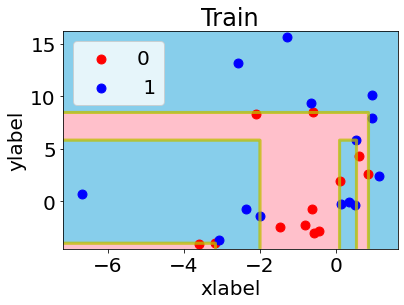

In [52]:
from sklearn.model_selection import train_test_split
# Visualise the decision area
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()
    
decision_region(X_train[:,:2],y_train,clf_2,title='Train',target_names=['0', ' 1'])

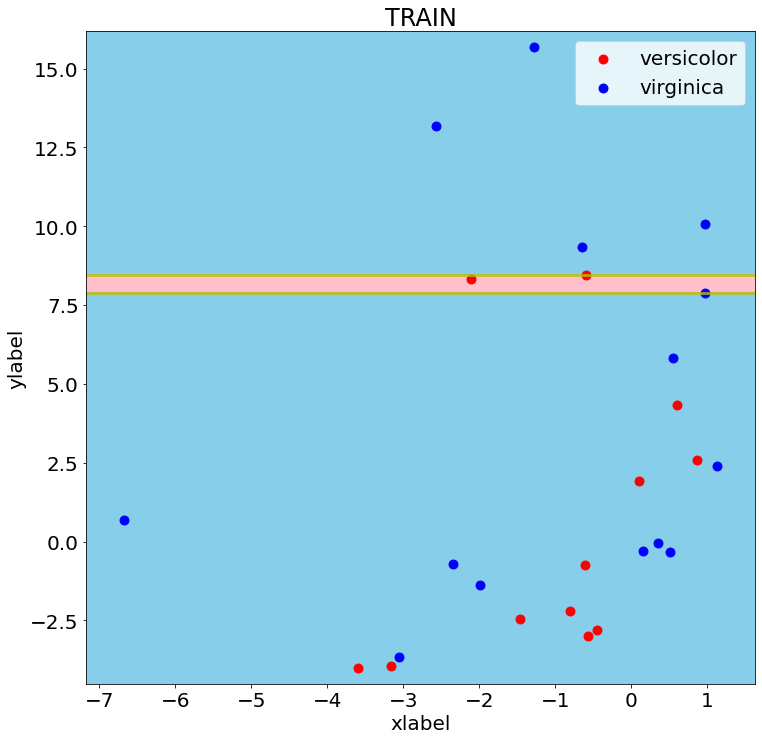

In [55]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
fit,ax=plt.subplots(figsize=(12,12))
plt.rcParams["font.size"]=20
decision_region(X_train,y_train,clf1,title='TRAIN')